# Load the Geometry of a Drawn Gene Character for Anylitcal Processing

In [1]:
import os
import xmltodict

import matplotlib.pyplot as plt
import numpy as np

from PIL import Image, ImageDraw
from random import randint, seed
from xmlparse import xmlToGeometry

import numpy as np

In [2]:
def loadRef(han_char, ref_dir = "Reference"):
    stroke_list = []
    frac_dists = []
    ref_path = f"{ref_dir}/{han_char[0]}000/{han_char}.han"
    ref_xml = open(ref_path, "r").read()
    root = xmltodict.parse(ref_xml)
    bounds = root["hanDefinition"]["bounds"]
    x_min, y_min, x_max, y_max = (float(bounds["@left"]), float(bounds["@bottom"]), float(bounds["@right"]), float(bounds["@top"]))
    scale = (int(x_max-x_min), int(y_max-y_min))
    strokes = root["hanDefinition"]["strokes"]["stroke"]
    for stroke in strokes:
        points = stroke["points"]["forward"]
        point_arr = []
        frac_arr = []
        for point in points["pointDistance"]:
            point_arr.append((float(point["@x"])-x_min,
                              float(point["@y"])-y_min))
            frac_arr.append(float(point["@fractionalDistance"]))
        stroke_list.append(np.array(point_arr))
        frac_dists.append(np.array(frac_arr))
    return stroke_list, frac_dists, scale
    

In [3]:
ref_g, ref_l, output_size = loadRef("5E7E", "Reference")

In [4]:
def loadGeometry(data_dir, han_char, output_size = (32, 32), f_read = None):
    """
    Loads geometric data about a gene characetr directly from the XML source
    """
    if f_read is None:
        dir_list = os.listdir(f"{data_dir}/{han_char}")
        dir_list.sort()
    else:
        dir_list = f_read
    g_data = []
    f_names = []
    for f in dir_list:
        flines = open(f"{data_dir}/{han_char}/{f}", "rb").readlines()
        f_names.append(flines[0].decode()[:-1])
    for f in f_names:
        g = xmlToGeometry(f, output_size)
        g_data.append(g)
    return g_data

def filterFalseEdges(g, l):
    """
    Filters out edges that are actually a series of points along the same line
    """
    pass


In [5]:
g, l = loadGeometry("HanBitmap", "5E7E", output_size, f_read = ["11000"])[0]
len(g)

12

In [6]:
def alignStrokes(strokes, ref, p_strokes, p_ref):
    stroke_map = np.full(len(strokes), -1)
    error_map = np.zeros((len(ref), len(strokes)), dtype=float)
    matches_tried = np.zeros(len(strokes), dtype=int)
    for i, ref_stroke, r_progresses in zip(range(len(ref)), ref, p_ref):
        for j, candidate_stroke, c_progresses in zip(range(len(strokes)), strokes, p_strokes):
            error_map[i, j] = strokeError(ref_stroke, candidate_stroke, r_progresses, c_progresses)
    for i, err in enumerate(error_map):
        candidate = np.argmin(err)
        stroke_map[candidate] = i
    # resolve conflicts until only one stroke is mapped to each reference stroke
    # the condition is based on the 'bad' candidates being set to -1, indicating no match
    while np.unique(stroke_map).shape[0] != len(strokes) - (len(strokes)-len(ref)-1 if len(strokes)-len(ref) > 1 else 0):
        # conflict resolution is still rudimentery
        for i in range(len(stroke_map)):
            if stroke_map[i] == -1:
                prios = np.argsort(error_map[:, i])
                stroke_map[i] = prios[matches_tried[i]]
        for i, conflicted in enumerate(stroke_map):
            if conflicted != -1:
                candidates = np.argwhere(stroke_map == i).flatten()
                if candidates.shape[0] > 1:
                    best_candidate = error_map[conflicted, candidates].argmin()
                    stroke_map[candidates] = -1
                    matches_tried[candidates] += 1
                    stroke_map[candidates[best_candidate]] = conflicted
                    matches_tried[best_candidate] -= 1
        matches_tried = matches_tried%len(ref)
    return stroke_map

def strokeError(stroke, ref_stroke, p_stroke, p_ref, mode="max"):
    forward_stroke_error, back_stroke_error = np.zeros(len(ref_stroke)), np.zeros(len(ref_stroke))
    forward_ref_error, back_ref_error = np.zeros(len(stroke)), np.zeros(len(stroke))
    for i, rpoint, rprogress in zip(range(len(ref_stroke)), ref_stroke, p_ref):
        forward_stroke_error[i] = np.linalg.norm((rpoint-strokeTrace(stroke, p_stroke, rprogress)))
    for i, rpoint, rprogress in zip(range(len(ref_stroke)), ref_stroke[::-1], p_ref[::-1]):
        back_stroke_error[i] = np.linalg.norm((rpoint-strokeTrace(stroke, p_stroke, 1-rprogress)))
    for i, point, progress in zip(range(len(stroke)), stroke, p_stroke):
        forward_ref_error[i] = np.linalg.norm((point-strokeTrace(ref_stroke, p_ref, progress)))
    for i, point, progress in zip(range(len(stroke)), stroke[::-1], p_stroke[::-1]):
        back_ref_error[i] = np.linalg.norm((point-strokeTrace(ref_stroke, p_ref, 1-progress)))
    final_error = min(forward_stroke_error.max()+forward_ref_error.max(), back_stroke_error.max()+back_ref_error.max())
    return final_error

def strokeTrace(stroke, stroke_progresses, progress):
    if progress == 1:
        return stroke[-1]
    progress_line = len(stroke_progresses)-1
    for i in range(1, len(stroke_progresses)):
        if stroke_progresses[i] > progress:
            progress_line = i-1
            break
    startp, endp = stroke_progresses[progress_line], stroke_progresses[progress_line+1]
    norm_progress = (progress-startp)/endp
    if stroke[progress_line+1][0] == stroke[progress_line][0]:
        x = stroke[progress_line][0]
        y = norm_progress*(stroke[progress_line+1][1]-stroke[progress_line][1])+stroke[progress_line][0]
    else:
        slope = (stroke[progress_line+1][1]-stroke[progress_line][1])/(stroke[progress_line+1][0]-stroke[progress_line][0])
        intercept = stroke[progress_line][1]-slope*stroke[progress_line][0]
        x = norm_progress*(stroke[progress_line+1][0]-stroke[progress_line][0])+stroke[progress_line][0]
        y = slope*x + intercept
    return np.array((x, y))


In [7]:
alignments = alignStrokes(g, ref_g, l, ref_l)
print(alignments)

[ 0  2  1  9  6  7  8 10 11 -1  4  3]


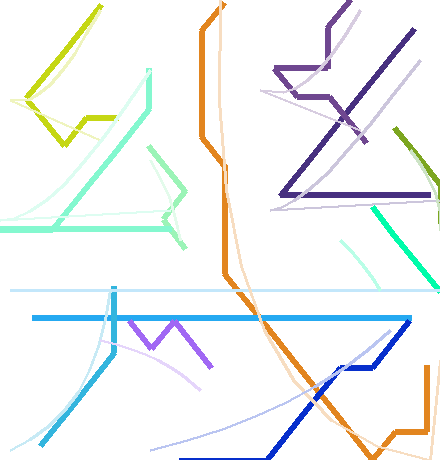

In [8]:
img = Image.new(mode="RGBA", size=output_size)
seed(ref_l[0][0])
colors = [(randint(0, 256), randint(0, 256), randint(0, 256)) for _ in range(len(ref_l)+1)]
colors_t = [(c[0], c[1], c[2], 70) for c in colors]

for i, r in enumerate(alignments):
    draw = ImageDraw.Draw(img)
    for a in range(len(g[i])-1):
        x1, y1 = g[i][a]
        x2, y2 = g[i][a+1]
        y1 = -(y1-output_size[1]/2)+output_size[1]/2
        y2 = -(y2-output_size[1]/2)+output_size[1]/2
        draw.line(((x1, y1), (x2, y2)), width=6, fill=colors[r])

for i, c in enumerate(colors_t[:-1]):
    draw = ImageDraw.Draw(img)
    for a in range(len(ref_g[i])-1):
        x1, y1 = ref_g[i][a]
        x2, y2 = ref_g[i][a+1]
        y1 = -(y1-output_size[1]/2)+output_size[1]/2
        y2 = -(y2-output_size[1]/2)+output_size[1]/2
        draw.line(((x1, y1), (x2, y2)), width=3, fill=c)
display(img)
#img.save("han_stroke_match_11000.png")